## Pretrained GAN

In [291]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Wandb

In [248]:
superpath = '/home/nik/superres/data/' 

In [249]:
supersrc = ImageImageList.from_folder(superpath).split_by_folder(train='train', valid='test')

In [250]:
#Filter items from supersrc so that you have only the *in.jpg items
supersrc.train = supersrc.train.filter_by_func(lambda x: (x.name.find('in.jpg') != -1))

In [251]:
supersrc.valid = supersrc.valid.filter_by_func(lambda x: (x.name.find('in.jpg') != -1))

In [252]:
# Filtered version 
supersrc

ItemLists;

Train: ImageImageList (4998 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /home/nik/superres/data;

Valid: ImageImageList (669 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /home/nik/superres/data;

Test: None

In [253]:
#ef ylabels(x):
#   if str(x)
supersrc = supersrc.label_from_func(lambda x: Path(str(x).replace('in.jpg','out.jpg')))

In [254]:
supersrc

LabelLists;

Train: LabelList (4998 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/nik/superres/data;

Valid: LabelList (669 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/nik/superres/data;

Test: None

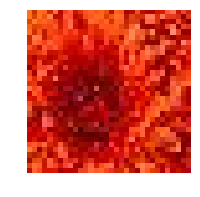

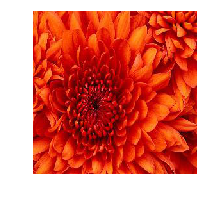

In [265]:
#LabelList with Indep and dep. variable
x,y = supersrc.train[0]
x.show()
y.show()

supersrc.train = supersrc.train.label_from_func(lambda x: Path(superpath,'train',x.name.replace('in.jpg','out.jpg')),from_item_lists=True)

supersrc.valid = supersrc.valid.label_from_func(lambda x: Path(superpath,'test',x.name.replace('in.jpg','out.jpg')),from_item_lists=True)

In [255]:
bs,size=32, 32
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

def get_superdata(bs,size):
    data = (supersrc.transform(get_transforms(max_zoom=1.), size=size, tfm_y=True)
           .databunch(bs=bs))

    data.c = 3
    return data

def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [266]:
def get_superdata(bs,size):
    data = (supersrc.databunch(bs=bs).normalize())

    data.c = 3
    return data

In [ ]:
superdata_gen = get_superdata(bs,size)
superdata_gen

In [272]:
#Grap one batch of data 
xb, yb = superdata_gen.one_batch()
xb.shape, yb.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32, 3, 256, 256]))

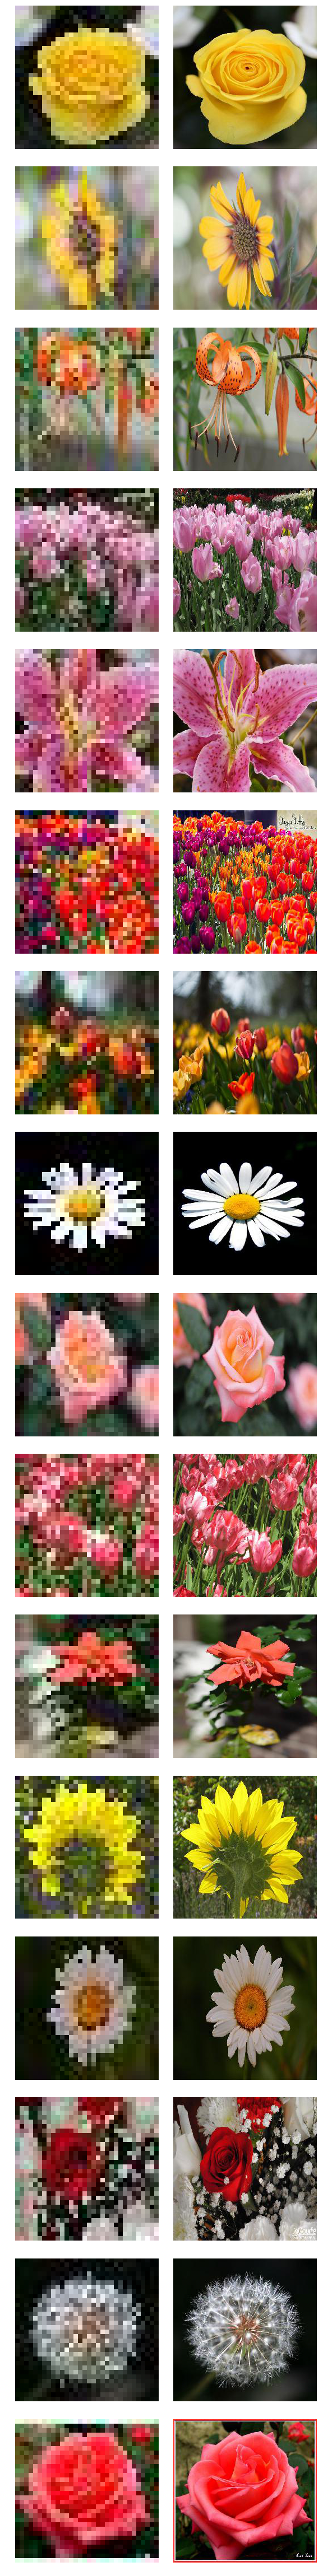

In [276]:
superdata_gen.show_batch(16)

#### Create a simplified version of an ML architecture


#### Recreate the Unet type of architecture

In [259]:
wd = 1e-3

y_range = (-3.,3.)

loss_gen = MSELossFlat()

In [280]:
def create_gen_learner():
    return unet_learner(superdata_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [281]:
learn_gen = create_gen_learner()

In [283]:
xbcuda = xb.cuda()
learn_gen(xb).shape

TypeError: 'Learner' object is not callable

In [278]:
learn_gen.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 16, 16]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 16, 16]         128        True      
______________________________________________________________________
ReLU                 [64, 16, 16]         0          False     
______________________________________________________________________
MaxPool2d            [64, 8, 8]           0          False     
______________________________________________________________________
Conv2d               [64, 8, 8]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 8, 8]           128        True      
______________________________________________________________________
ReLU                 [64, 8, 8]           0          False     
__________________________________________________

In [262]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

/home/nik/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([6291456])) that is different to the input size (torch.Size([98304])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (98304) must match the size of tensor b (6291456) at non-singleton dimension 0

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

In [ ]:
learn_gen.show_results(rows=4)

## Crappified data

Prepare the input data by crappifying images.

In [293]:
from crappify import *

Uncomment the first time you run this notebook.

In [294]:
#il = ImageList.from_folder(path_hr)
#parallel(crappifier(path_lr, path_hr), il.items)

For gradual resizing we can change the commented line here.

In [319]:
bs,size=32, 256
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [320]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [321]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [322]:
data_gen.items[0]

PosixPath('/home/nik/.fastai/data/oxford-iiit-pet/crappy/basset_hound_67.jpg')

In [323]:
data_gen = get_data(bs,size)

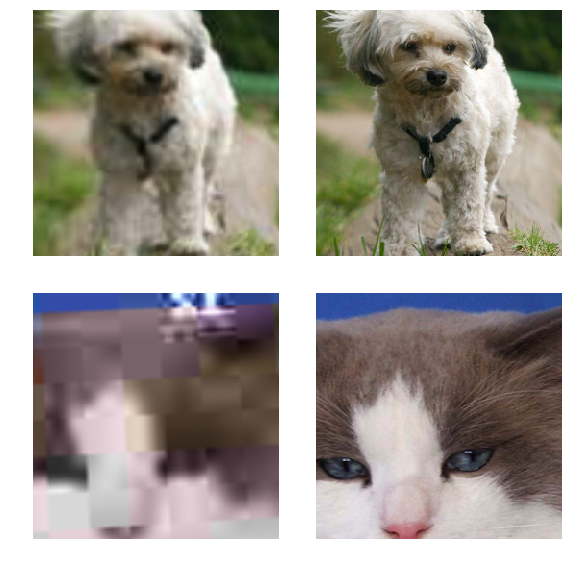

In [324]:
data_gen.show_batch(2)

In [325]:
src

LabelLists;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/nik/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/nik/.fastai/data/oxford-iiit-pet/crappy;

Test: None

In [326]:
wd = 1e-3

In [327]:
y_range = (-3.,3.)

In [328]:
loss_gen = MSELossFlat()

In [329]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [330]:
learn_gen = create_gen_learner()

In [331]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

RuntimeError: CUDA out of memory. Tried to allocate 768.00 MiB (GPU 0; 10.92 GiB total capacity; 7.62 GiB already allocated; 688.75 MiB free; 84.03 MiB cached)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

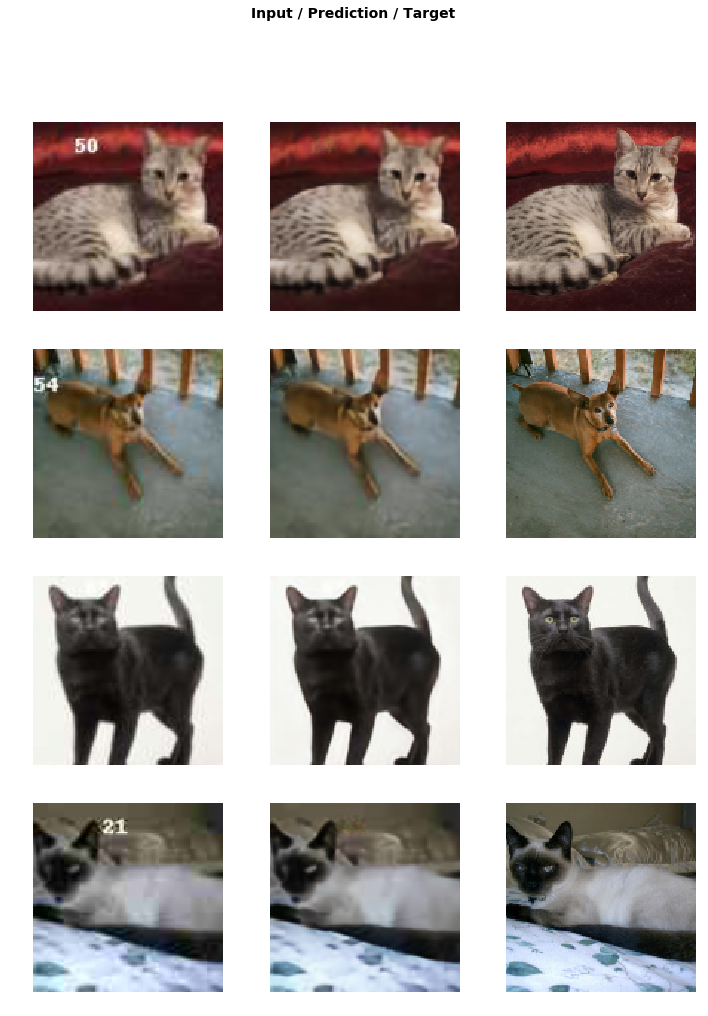

In [ ]:
learn_gen.show_results(rows=4)

In [ ]:
learn_gen.save('gen-pre2')

## Save generated images

In [ ]:
learn_gen.load('gen-pre2');

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
# shutil.rmtree(path_gen)

In [ ]:
path_gen.mkdir(exist_ok=True)

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [ ]:
save_preds(data_gen.fix_dl)

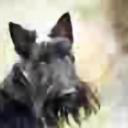

In [ ]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [ ]:
learn_gen=None
gc.collect()

3755

Pretrain the critic on crappy vs not crappy.

In [ ]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [ ]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

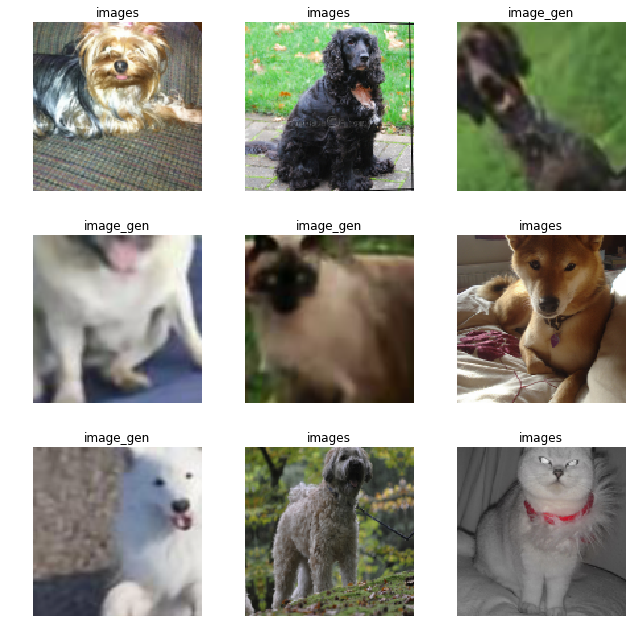

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

In [ ]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

15794

In [ ]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
lr = 1e-4

In [ ]:
learn.fit(40,lr)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

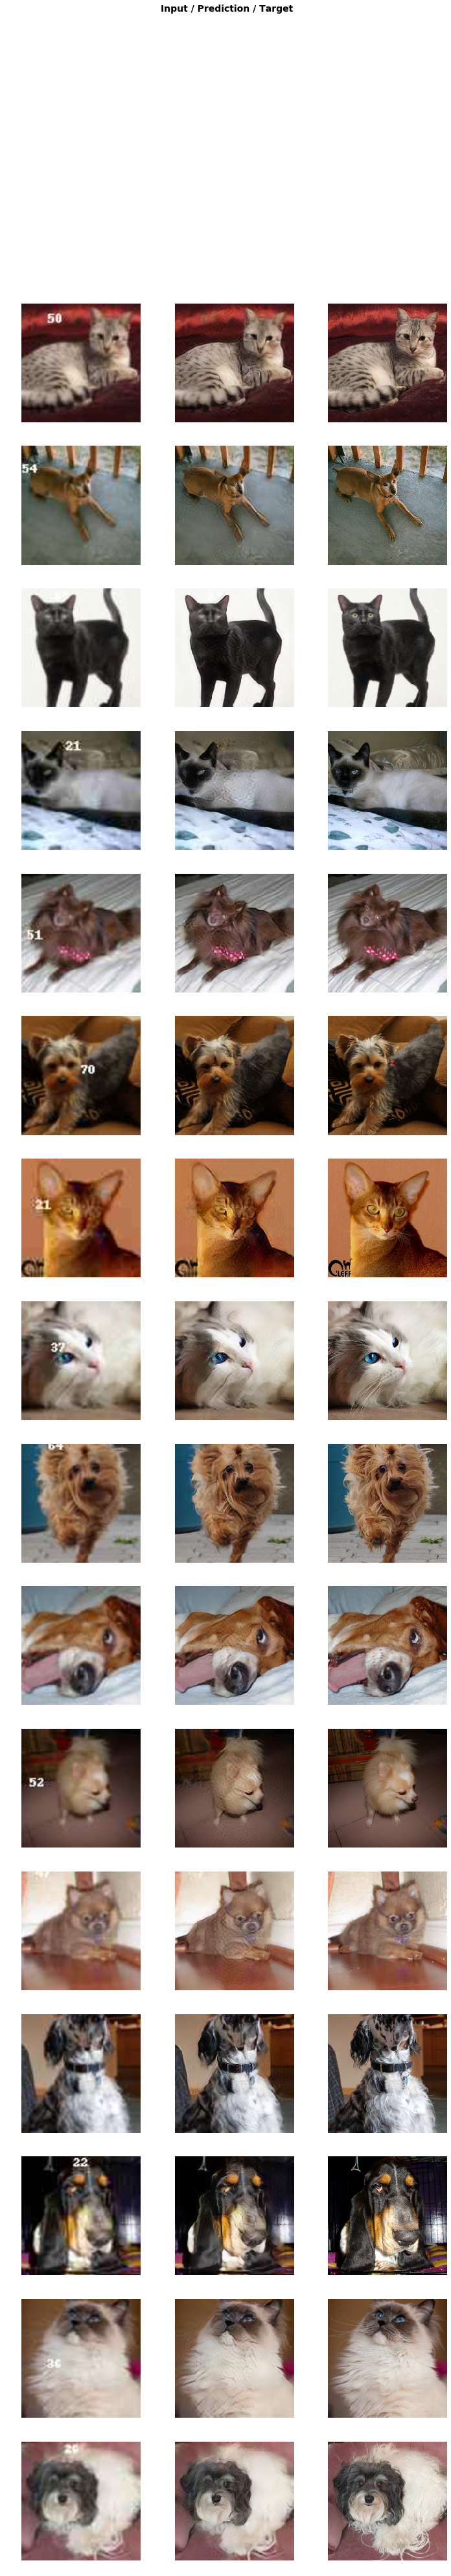

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

## fin